# Pneumonia Classification with fast.ai

This is a pneumonia classification model using fast.ai v 1.0. This dataset comes from the [Kaggle RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). The dataset includes ~ 26,000 training images and 1,000 test images in DICOM format from chest x-ray images. I used [IrfanView](https://www.irfanview.com/) to convert all image files into .jpg format. 

I have made significant modifications in order to get better results in the classifier. In the original challenge, images are only classified as either having pneumonia or not. I have isntead divided the images into four classes: 

1.   **Normal.** Patient has no visible issues. 
2.   **Opacity-1.** Patient has only 1 pneumonia-related lung opacity. 
3. **Opacity-2.** Patient has 2 or more pneumonia-related lung opacity. 
4. **Abnormal.** Patient does not have pneumonia but has another issue or condition. 

This is a very difficult computer vision challenge. In further notebooks, I'll expand upon other methods for dealing with this dataset, but this one will focus on simple classification. Note that while I have divided the dataset into 4 classes, in reality, we only have 3 as "Opacity-1" and "Opacity-2" images are the same class: patient has pneumonia. 

With a 2,000 image sample, I was able to achieve 69% accuracy in the 3-class model. Upping the model to all 26,000 images, I was able to achieve about 74% accuracy. 

The biggest difficult with the full dataset was that the model sometimes has difficulty distinguishing between patients with pneumonia related lung opacities versus other conditions (e.g. pleural effusion). Work on future models will deal with trying to improve upon this performance. However, there are some significant limitations in that the "abnormal" images are not labeled by condition or disease; we merely know that they have some condition. Without medical training, I lack the expertise to further improve the classifier by labeling these individual conditions. 

# Get Data

In [0]:
# image zip upload
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pneu_all_sm.zip to pneu_all_sm.zip
User uploaded file "pneu_all_sm.zip" with length 804296984 bytes


In [0]:
# csv upload
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving malaria_parasites_5000.csv to malaria_parasites_5000.csv
User uploaded file "malaria_parasites_5000.csv" with length 532878 bytes


In [0]:
!ls

pneu_2000_sm.zip  sample_data


In [0]:
!unzip -qq pneu_2000_sm.zip

In [0]:
!ls

pneu_2000_sm  pneu_2000_sm.zip	sample_data


In [0]:
!ls pneu_2000_sm | head

abnormal
normal
opacity_1
opacity_2


In [0]:
!rm pneu_2000_sm.zip

In [0]:
!ls

pneu_2000_sm  sample_data


In [0]:
!ls pneu_2000_sm/opacity_1 | head

03d92597-3e33-4fdf-8db5-a27cf5b8d3eb.jpg
049d7317-5a8b-4fc4-b81f-159fe6b45a92.jpg
04a6aa6d-bd6d-48b1-822b-21b81c4bdf3a.jpg
04d59a79-e659-49ca-8790-511f89ac3e1b.jpg
04dd9347-6215-4b34-a98f-a73e577aff9d.jpg
05083068-f4df-464a-b669-3c084ee05f1f.jpg
051e6e97-fda7-4b5c-8d5f-084bf3607d22.jpg
0587782c-ac6b-4ae1-8ffb-ce894d09f75e.jpg
059f1e59-573c-49d1-ac78-3323a2ff047f.jpg
05dad446-45f7-44df-bd2f-4673d9502348.jpg


# Imports and Installations

In [0]:
# fast ai installations
!pip install fastai
!pip install torchtext

    100% |████████████████████████████████| 153kB 13.0MB/s 
    100% |████████████████████████████████| 61kB 19.2MB/s 
    100% |████████████████████████████████| 112kB 28.2MB/s 
    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60c98000 @  0x7fd03d53f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built nvidia-ml-py3 bottleneck
torchvision 0

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [0]:
# check to make sure GPU is on
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.0.0
True
True


#Path + Parameters

In [0]:
%cd ..

/


In [0]:
!ls

bin	    content  etc   lib32  mnt	root  srv    tmp    var
boot	    datalab  home  lib64  opt	run   swift  tools
colabtools  dev      lib   media  proc	sbin  sys    usr


In [0]:
PATH = Path("content/")
os.makedirs(PATH, exist_ok=True)

In [0]:
IMAGES = 'pneu_2000_sm'
IMG_PATH = Path("content/pneu_2000_sm/")

In [0]:
!ls {PATH}

pneu_all_sm  sample_data


# Model on 2000 Images

In [0]:
# architechture
arch = models.resnet34

In [0]:
data = ImageDataBunch.from_folder(path=PATH, train=IMAGES, 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [0]:
# data = ImageDataBunch.from_csv(path=PATH, folder=IMAGES, csv_labels=labels, valid_pct=0.2, 
#                                ds_tfms=get_transforms(flip_vert=True, max_warp=0),
#                                size=224,bs=64,num_workers=0).normalize(imagenet_stats)

# data = ImageDataBunch.from_csv(`path`:PathOrStr, `folder`:PathOrStr=`'.'`, `sep`=`None`, `csv_labels`:PathOrStr=`'labels.csv'`, 
#                                `valid_pct`:float=`0.2`, `fn_col`:int=`0`, `label_col`:int=`1`, `suffix`:str=`''`, 
#                                `header`:Union[int, str, NoneType]=`'infer'`, `kwargs`:Any)


In [0]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['abnormal', 'normal', 'opacity_1', 'opacity_2']


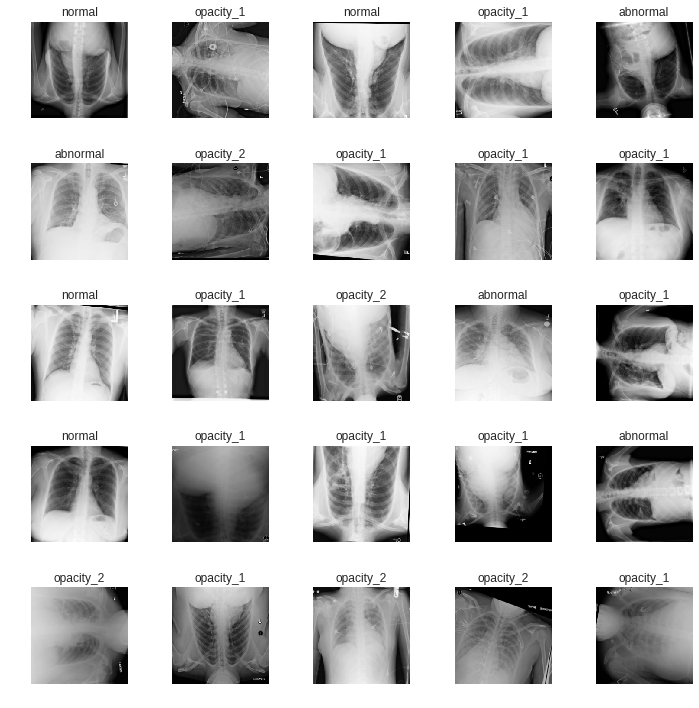

In [0]:
data.show_batch(rows=5, figsize=(10,10))

In [0]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 21832352.13it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


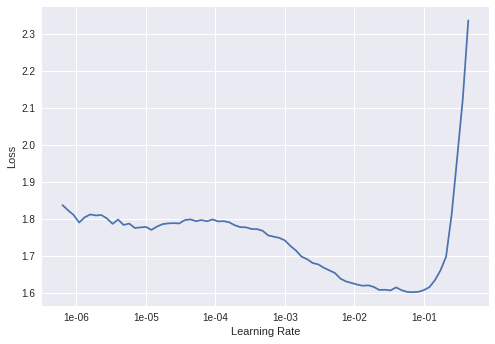

In [0]:
learn.lr_find()
learn.recorder.plot()

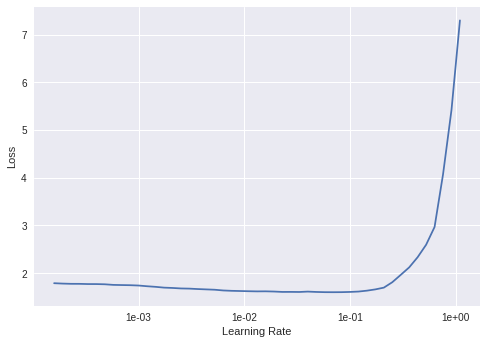

In [0]:
# fix chart to see relevant portion
learn.recorder.plot(skip_start=40, skip_end=0)

# old format
# learn.sched.plot(n_skip=0, n_skip_end=1)

In [0]:
learn.fit_one_cycle(6,1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.704110,1.291069,0.387500
2,1.529980,1.147248,0.502500
3,1.426033,1.116419,0.525000
4,1.352019,1.119561,0.502500
5,1.286141,1.108587,0.507500
6,1.246614,1.096293,0.510000


In [0]:
learn.save('stage_one')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


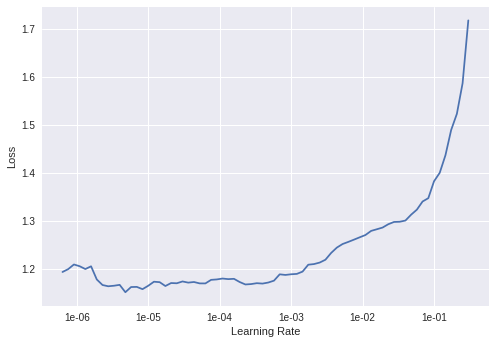

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))

epoch,train_loss,valid_loss,accuracy
1,1.189014,1.078675,0.525000
2,1.169919,1.072461,0.540000
3,1.155822,1.075784,0.527500
4,1.138775,1.073552,0.522500


In [0]:
learn.save('stage_2')

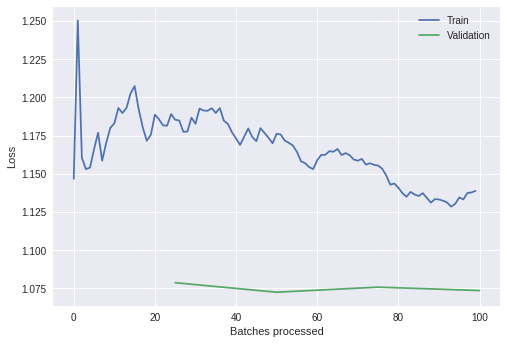

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit(epochs=10, lr=5e-6)

epoch,train_loss,valid_loss,accuracy
1,1.121789,1.063888,0.530000
2,1.129915,1.059158,0.537500
3,1.113535,1.062672,0.550000
4,1.121056,1.058015,0.532500
5,1.101572,1.068699,0.545000
6,1.106376,1.048948,0.555000
7,1.104637,1.042912,0.562500
8,1.091204,1.038604,0.562500
9,1.090538,1.046674,0.560000
10,1.088715,1.031751,0.565000


In [0]:
learn.save('stage_3')

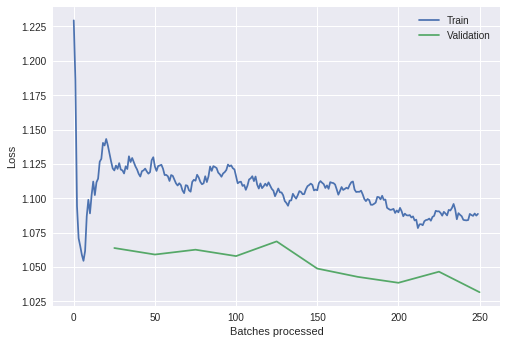

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit(epochs=50, lr=5e-6)

epoch,train_loss,valid_loss,accuracy
1,1.074235,1.037929,0.562500
2,1.071644,1.027484,0.560000
3,1.063316,1.020271,0.577500
4,1.058126,1.023257,0.572500
5,1.051151,1.030586,0.572500
6,1.042078,1.027627,0.572500
7,1.044691,1.024924,0.572500
8,1.037766,1.025305,0.570000
9,1.030767,1.021725,0.562500
10,1.025084,1.020867,0.565000


In [0]:
learn.save('stage_4')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

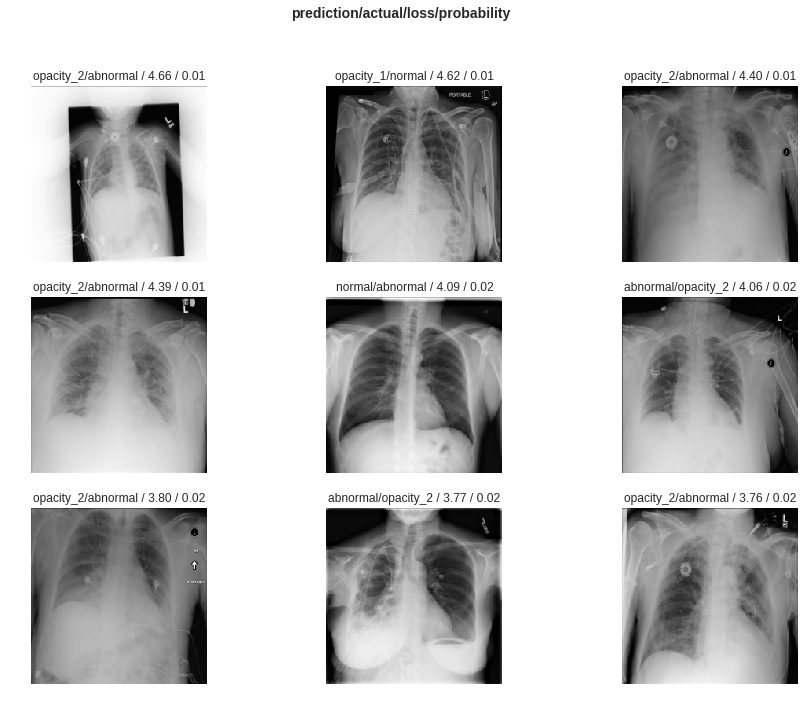

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

# Confusion Matrix

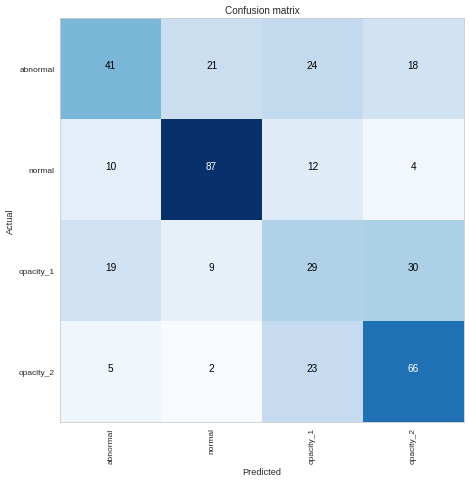

In [0]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 41), ('Uninfected', 'Parasitized', 28)]

# Load All Images

In [0]:
!ls

pneu_all_sm.zip  sample_data


In [0]:
!unzip -qq pneu_all_sm.zip

In [0]:
!ls

pneu_all_sm  pneu_all_sm.zip  sample_data


In [0]:
!ls pneu_all_sm | head

abnormal
normal
opacity_1
opacity_2


In [0]:
!rm pneu_all_sm.zip

In [0]:
!ls

pneu_all_sm  sample_data


In [0]:
!ls pneu_all_sm/opacity_1 | head

03d92597-3e33-4fdf-8db5-a27cf5b8d3eb.jpg
049d7317-5a8b-4fc4-b81f-159fe6b45a92.jpg
04a6aa6d-bd6d-48b1-822b-21b81c4bdf3a.jpg
04d59a79-e659-49ca-8790-511f89ac3e1b.jpg
04dd9347-6215-4b34-a98f-a73e577aff9d.jpg
05083068-f4df-464a-b669-3c084ee05f1f.jpg
051e6e97-fda7-4b5c-8d5f-084bf3607d22.jpg
0587782c-ac6b-4ae1-8ffb-ce894d09f75e.jpg
059f1e59-573c-49d1-ac78-3323a2ff047f.jpg
05dad446-45f7-44df-bd2f-4673d9502348.jpg


# SET PATHS

In [0]:
%cd ..

/


In [0]:
!ls

bin	    content  etc   lib32  mnt	root  srv    tmp    var
boot	    datalab  home  lib64  opt	run   swift  tools
colabtools  dev      lib   media  proc	sbin  sys    usr


In [0]:
PATH = Path("content/")
os.makedirs(PATH, exist_ok=True)

In [0]:
IMAGES_ALL = 'pneu_all_sm'
IMG_ALL_PATH = Path("content/pneu_all_sm/")

In [0]:
!ls {PATH}

pneu_all_sm  sample_data


# Model on 26K Images

In [0]:
# architechture
arch = models.resnet34

In [0]:
data = ImageDataBunch.from_folder(path=PATH, train=IMAGES_ALL, 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [0]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['abnormal', 'normal', 'opacity_1', 'opacity_2']


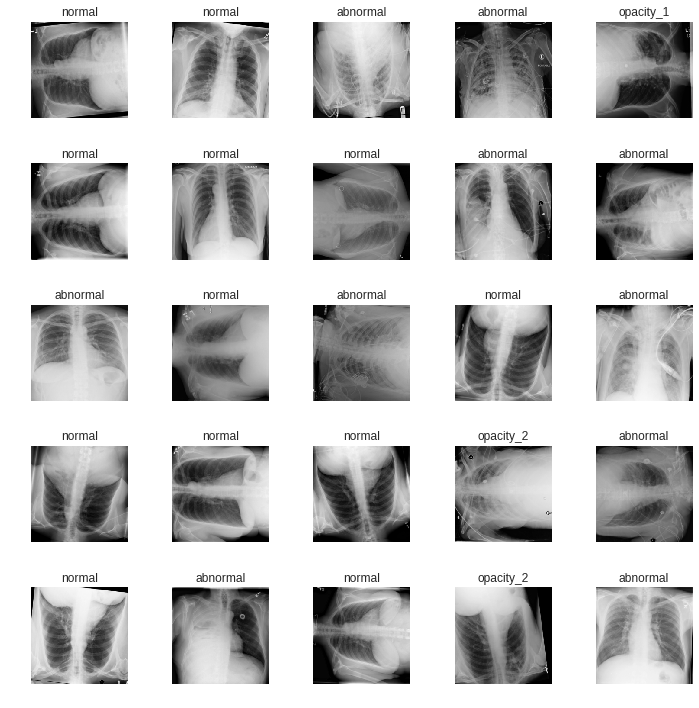

In [0]:
data.show_batch(rows=5, figsize=(10,10))

In [0]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 70607552.16it/s]


epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


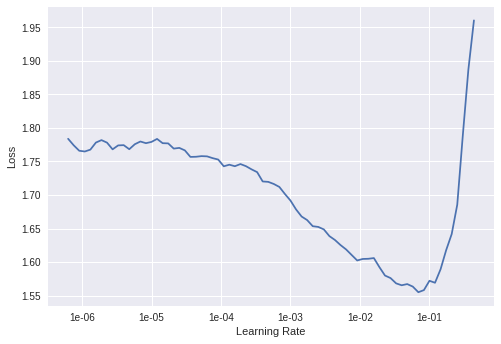

In [0]:
learn.lr_find()
learn.recorder.plot()

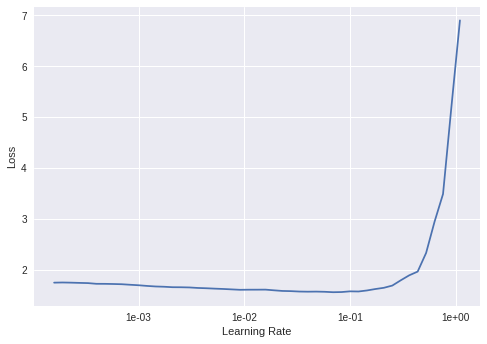

In [0]:
# fix chart to see relevant portion
learn.recorder.plot(skip_start=40, skip_end=0)

# old format
# learn.sched.plot(n_skip=0, n_skip_end=1)

In [0]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.897593,0.858665,0.658736
2,0.899487,0.953684,0.566888
3,0.853422,1.003223,0.587363
4,0.806592,0.786872,0.679212
5,0.796396,0.741036,0.695593
6,0.760418,0.727696,0.700078


In [0]:
learn.save('all1')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


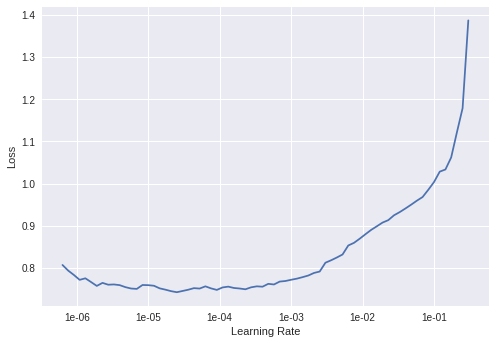

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,5e-5 ))

epoch,train_loss,valid_loss,accuracy
1,0.766463,0.725303,0.700078
2,0.749404,0.723546,0.699688
3,0.740017,0.719022,0.700858
4,0.719883,0.713438,0.704368


In [0]:
learn.save('all2')

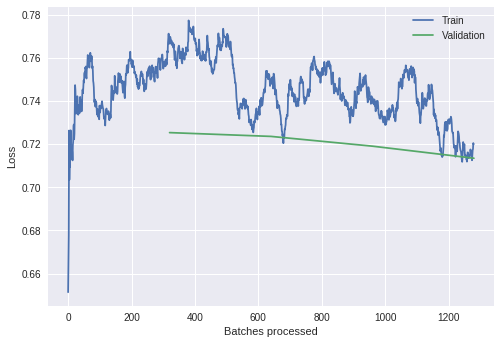

In [0]:
learn.recorder.plot_losses()

In [0]:
# last run cell
learn.fit(epochs=5, lr=5e-5)

epoch,train_loss,valid_loss,accuracy
1,0.755967,0.736428,0.701443
2,0.758295,0.726690,0.704758
3,0.746911,0.729470,0.698713
4,0.734277,0.705027,0.712169
5,0.715956,0.708481,0.715094


In [0]:
learn.save('all3')

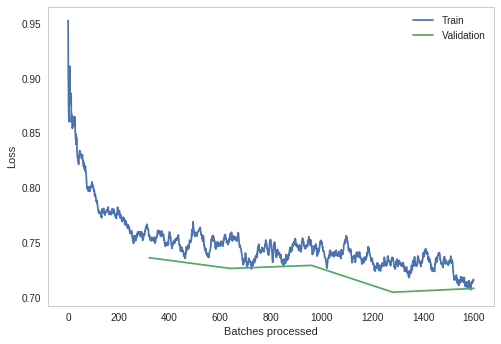

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit(epochs=5, lr=5e-5)

epoch,train_loss,valid_loss,accuracy
1,0.727745,0.701992,0.711583
2,0.718495,0.708697,0.713144
3,0.726835,0.696311,0.714704
4,0.711991,0.693119,0.721139
5,0.694503,0.689189,0.726014


In [0]:
learn.save('all4')

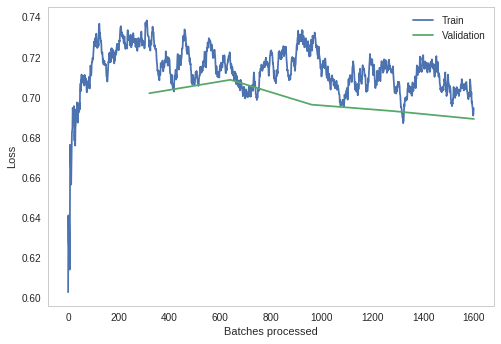

In [0]:
learn.recorder.plot_losses()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

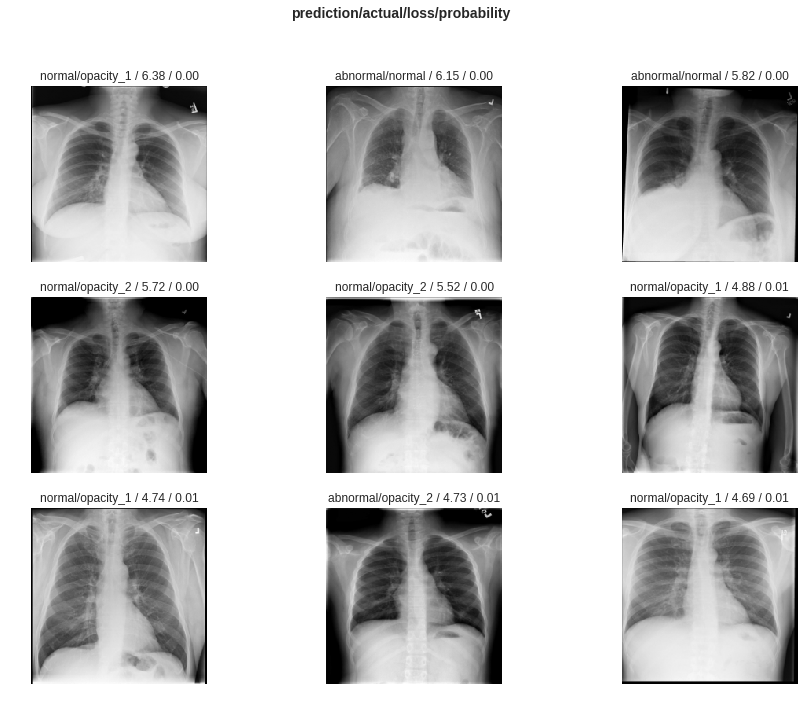

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

# Confusion Matrix 26K Images

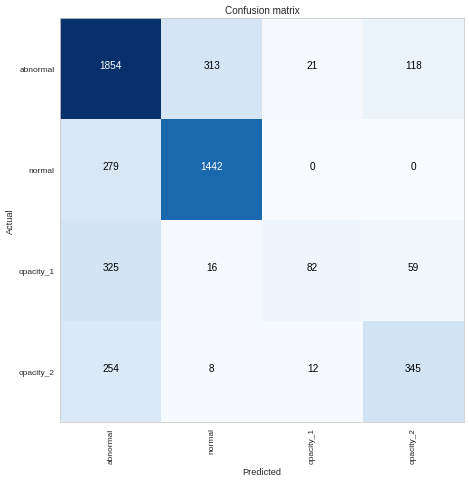

In [0]:
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
learn.data

ImageDataBunch;

Train: LabelList
y: CategoryList (20513 items)
[Category normal, Category normal, Category normal, Category normal, Category normal]...
Path: content
x: ImageItemList (20513 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: content;

Valid: LabelList
y: CategoryList (5128 items)
[Category opacity_1, Category abnormal, Category opacity_2, Category normal, Category abnormal]...
Path: content
x: ImageItemList (5128 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: content;

Test: None

## 74% Accuracy

In [0]:
valid_images = 5128

class_correct = 1854+1442+82+345+12+59
print(class_correct)

real_accuracy = class_correct / valid_images
print(real_accuracy)

3794
0.7398595943837754


In [0]:
interp.most_confused(min_val=2)

[('opacity_1', 'abnormal', 325),
 ('abnormal', 'normal', 313),
 ('normal', 'abnormal', 279),
 ('opacity_2', 'abnormal', 254),
 ('abnormal', 'opacity_2', 118),
 ('opacity_1', 'opacity_2', 59),
 ('abnormal', 'opacity_1', 21),
 ('opacity_1', 'normal', 16),
 ('opacity_2', 'opacity_1', 12),
 ('opacity_2', 'normal', 8)]